In [1]:
# Import required libraries
import torch
import torchvision
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import os
import json

# Import DetectionMetrics components
from detectionmetrics.datasets.yolo import YOLODataset
from detectionmetrics.models.torch_detection import TorchImageDetectionModel

# Set up matplotlib for better visualization
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
Tensorflow not available


In [2]:
# Create directories for data
!mkdir -p local/data/models
!mkdir -p local/outputs

# Init dataset (```YOLODataset```)
We must provide:
- YAML dataset configuration file.
- Dataset directory that contains images and annotations for each split. It overrides the ```path``` parameter in the YAML file.

In [ ]:
# Initialize YOLO dataset
dataset_fname = "~/datasets/taco/TACObboxSkewedResized.yaml"
dataset_dir = "~/datasets/taco/TACOskewedBBoxResized"


# Load dataset
dataset = YOLODataset(dataset_fname=dataset_fname, dataset_dir=dataset_dir)
print(f"Dataset loaded with {len(dataset.dataset)} samples")
print(f"Number of classes: {len(dataset.ontology)}")

Dataset loaded with 1500 samples
Number of classes: 28


# Init object detection model (```TorchImageDetectionModel```)
We must provide:
- Model path (torch .pt file).
- Model JSON configuration file.
- Ontology JSON file. It defines the classes predicted by the model. Tipically, the same as the dataset ontology.

In the following cell we build these files programmatically.

In [ ]:
# Create a pre-trained detection model
model = torchvision.models.detection.maskrcnn_resnet50_fpn(weights="DEFAULT")
model.eval()

# Save the model
model_path = "local/data/models/maskrcnn_model.pt"
os.makedirs(os.path.dirname(model_path), exist_ok=True)
torch.save(model, model_path)
model_cfg = {
    "batch_size": 1,
    "num_workers": 0,
    "confidence_threshold": 0.5,
    "nms_threshold": 0.3
}
config_path = "local/data/models/maskrcnn_config.json"
with open(config_path, "w") as f:
    json.dump(model_cfg, f, indent=2)

ontology_path = "local/data/models/coco_model_ontology.json"
with open(ontology_path, "w") as f:
    json.dump(dataset.ontology, f, indent=2)

print("Model and configuration saved!")

Model and configuration saved!


In [12]:
detection_model = TorchImageDetectionModel(
    model=model_path,
    model_cfg=config_path,
    ontology_fname=ontology_path  # This is the model ontology (indices as keys)
)

print("Detection model initialized!")

Model is not a TorchScript model. Loading as native PyTorch model.
Detection model initialized!


# Single inference example

In [13]:
# Function to visualize detection results
def visualize_detections(image, predictions, ground_truth=None, title="Detection Results"):
    """Visualize detection predictions and optionally ground truth."""
    fig, ax = plt.subplots(1, 1, figsize=(12, 8))
    
    # Display image
    ax.imshow(image)
    
    #map labels to class names
    label_to_name = {v['idx'] : k for k, v in dataset.ontology.items()}

    # Draw prediction boxes
    if predictions and isinstance(predictions, dict) and 'boxes' in predictions:
        boxes = predictions['boxes'].cpu().numpy()
        scores = predictions['scores'].cpu().numpy()
        labels = predictions['labels'].cpu().numpy()
        
        for i, (box, score, label) in enumerate(zip(boxes, scores, labels)):
            # Convert [x1, y1, x2, y2] to [x, y, width, height]
            x1, y1, x2, y2 = box
            width = x2 - x1
            height = y2 - y1
            
            # Get class name
            class_name = label_to_name.get(label, str(label))
            
            # Create rectangle patch
            rect = patches.Rectangle(
                (x1, y1), width, height,
                linewidth=2, edgecolor='red', facecolor='none', alpha=0.7
            )
            ax.add_patch(rect)
            
            # Add label
            ax.text(x1, y1-5, f'{class_name}: {score:.2f}', 
                   color='red', fontsize=10, weight='bold')
    
    # Draw ground truth boxes (if provided)
    if ground_truth and isinstance(ground_truth, tuple) and len(ground_truth) >= 2:
        gt_boxes, gt_labels = ground_truth
        
        for i, (box, label) in enumerate(zip(gt_boxes, gt_labels)):
            # Convert [x1, y1, x2, y2] to [x, y, width, height]
            x1, y1, x2, y2 = box
            width = x2 - x1
            height = y2 - y1
            
            # Get class name
            class_name = label_to_name.get(label, str(label))
            
            rect = patches.Rectangle(
                (x1, y1), width, height,
                linewidth=2, edgecolor='green', facecolor='none', alpha=0.7
            )
            ax.add_patch(rect)
            
            ax.text(x1, y1+height+5, f'GT: {class_name}', 
                   color='green', fontsize=10, weight='bold')
    
    ax.set_title(title)
    ax.axis('off')
    plt.tight_layout()
    plt.show()

 Testing inference on: /home/dpascualhe/datasets/taco/TACOskewedBBoxResized/TACOskewedBBoxResized/images/train/1328.jpg
   Image size: (640, 640)
 Found 1 detections
 Ground truth: 13 objects


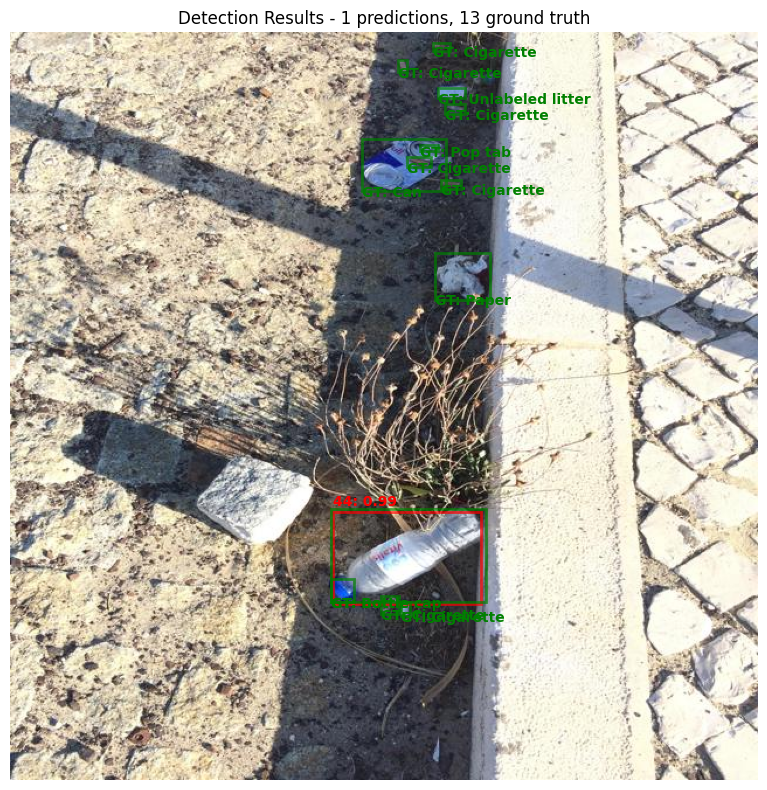

In [18]:
# Test inference on a single image
if 'dataset' in locals() and len(dataset.dataset) > 0:
    # Make filenames global first
    dataset.make_fname_global()
    
    # Get first image from dataset
    sample_idx = 125
    image_path = dataset.dataset.iloc[sample_idx]['image']
    
    # Load and display original image
    image = Image.open(image_path).convert('RGB')
    print(f" Testing inference on: {image_path}")
    print(f"   Image size: {image.size}")
    
    # Run inference
    predictions = detection_model.inference(image)
    
    print(f" Found {len(predictions['boxes'])} detections")
    # Get ground truth for comparison
    annotation_path = dataset.dataset.iloc[sample_idx]['annotation']
    ground_truth = dataset.read_annotation(annotation_path)
    
    print(f" Ground truth: {len(ground_truth[0])} objects")

    # Visualize results
    visualize_detections(
        np.array(image), 
        predictions, 
        ground_truth,
        title=f"Detection Results - {len(predictions['boxes'])} predictions, {len(ground_truth[0])} ground truth"
    )
else:
    print(" Dataset not loaded. Please check the data paths above.")

In [ ]:
# Run evaluation on a subset of the dataset
# For demonstration, we'll use a small subset
if 'dataset' in locals():
    
    # Make sure the output directory exists
    predictions_outdir = "local/outputs/detection_preds"
    os.makedirs(predictions_outdir, exist_ok=True)
    
    try:
        # Run evaluation with ontology translation
        results = detection_model.eval(
            dataset=dataset,
            split="test",
            predictions_outdir=predictions_outdir,
            results_per_sample=True
        )
        
        print(" Evaluation completed!")
        
    except Exception as e:
        print(f" Evaluation failed: {e}")
        import traceback
        traceback.print_exc()
else:
    print("  Dataset not loaded. Please check the data paths above.")


  0%|          | 0/75 [00:00<?, ?it/s]

 Evaluation completed!


In [20]:
results

,Aluminium foil,Battery,Blister pack,Bottle,Bottle cap,Broken glass,Can,Carton,Cup,Food waste,...,Rope & strings,Scrap metal,Shoe,Squeezable tube,Straw,Styrofoam piece,Unlabeled litter,Cigarette,mean,mAP
AP,0.0,0.0,NaN,0.011364,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.000517,0.000253
Precision,0.0,0.0,NaN,0.090909,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.004132,NaN
Recall,0.0,0.0,NaN,0.038462,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.001748,NaN
TP,0.0,0.0,NaN,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.045455,NaN
FP,0.0,18.0,NaN,10.000000,1.0,0.0,0.0,0.0,0.0,5.0,...,1.0,NaN,NaN,NaN,0.0,0.0,0.0,3.0,2.363636,NaN
FN,3.0,0.0,NaN,25.000000,10.0,2.0,26.0,12.0,10.0,1.0,...,1.0,NaN,NaN,NaN,6.0,6.0,21.0,27.0,10.681818,NaN
